In [51]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        self.initial_scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) +Z
        return self.out(Z)




In [52]:
X_low = np.array([-0.02])  # wealth lower bound
X_high = np.array([2])          # wealth upper bound


# neural network parameters
num_layers_FFNN = 4
num_layers_RNN = 0
nodes_per_layer = 50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'
# Training parameters
sampling_stages  = 6000   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 256
nSim_boundary = 1

dim_input = 1
dim_output = 2
 
model = DCGMNet(X_low, X_high,  
                 dim_input, dim_output, 
                 num_layers_FFNN, nodes_per_layer,
                 activation_FFNN)





In [53]:
# Aiyagari problem parameters
gamma = 2
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var

z1 = .1
z2 = .2
z = np.array([z1, z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1, la2])

eps = tf.constant(1e-10, dtype=tf.float32)


def u(c):
    return c**(1-gamma)/(1-gamma)


def u_deriv(c):
    return c**(-gamma)


def u_deriv_inv(c):
    return c**(-1/gamma)


In [54]:

def sampler(nSim_interior, nSim_boundary):
    ''' Sample space points from the function's domain
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at boundary to sample 
    ''' 
    
    # Sampler #1: domain interior    

    X_interior = tf.random.uniform(
        shape=[nSim_interior, 1], minval=X_low, maxval=X_high, dtype=tf.float32)


    a_alower = X_low[0] * tf.ones(shape = (nSim_boundary, 1), dtype=tf.float32)
    X_alower = a_alower

    return X_interior, X_alower

def control_c(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.gradients(V, a)[0]

    V_a = tf.maximum(1e-10 * tf.ones_like(V), V_a)

    c = u_deriv_inv(V_a)
    
    return c

def value_info(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    c = u_deriv_inv(V_a)
    
    s1 = z[0]*tf.ones_like(a)[:,0:1]+r*a[:,0:1]-c[:,0:1]
    s2 = z[1]*tf.ones_like(a)[:,0:1]+r*a[:,0:1]-c[:,1:2]
    s = tf.concat([s1[:,0:1],s2[:,0:1]],axis=1)

    return V, V_a, s



def loss_differentialoperator(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum(eps*tf.ones_like(V), V_a)


    c = u_deriv_inv(V_a)
    u_c = u(c) 
    
    diff_V_z1 = -rho * V[:, 0] + u_c[:, 0] + V_a[:, 0] * (z[0]+r*a[:, 0]-c[:, 0]) + la[0] * (V[:, 1] - V[:, 0])
    diff_V_z2 = -rho * V[:, 1] + u_c[:, 1] + V_a[:,1] * (z[1]+r*a[:,0]-c[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        
    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_differentialoperator_alower(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum( tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z+ r* a), V_a)

    c_new = u_deriv_inv(V_a_new)
    u_c_new = u(c_new) 
    

    diff_V_z1 = -rho * V[:,0] + u_c_new[:,0] + V_a[:,0]*(z[0]+r*a[:,0]-c_new[:,0]) + la[0]* (V[:,1] - V[:,0])
    diff_V_z2 = -rho * V[:,1] + u_c_new[:,1] + V_a[:,1]*(z[1]+r*a[:,0]-c_new[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        

    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_concave(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_aa = tf.concat([tf.gradients(V_a[:,0], a)[0],tf.gradients(V_a[:,1], a)[0]],axis=1)
    concave_V = tf.maximum(V_aa, tf.zeros_like(V))

    L = tf.reduce_mean( tf.square(concave_V ) )
    return L


def compute_loss(model, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    ''' 

    Loss_V_interior, L1 = loss_differentialoperator(model, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower(model, X_alower)
    
    L3 =  loss_concave(model, X_interior)

    L4 = tf.cast(0,tf.float32)

    L = L1 + L2 + L3 + L4
    
    return L
    
    
def get_grad(model, X_interior, X_alower):
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_interior, X_alower)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, grad


In [55]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=starting_learning_rate)


@tf.function
def train_step(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_interior, X_alower)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(nSim_interior, nSim_boundary)

    for _ in range(steps_per_sample):
        loss = train_step(X_interior, X_alower)
    
    hist.append(loss.numpy())
    
    if i%100==0:
        tf.print(i,loss)
    

0 63.6229439
100 1.39927661
200 0.110553212
300 0.0710094944
400 0.00518071419
500 0.00175297039
600 0.0204796419
700 0.000604039
800 0.00176751241
900 0.000398239674
1000 0.000141580342
1100 4.85544733e-05
1200 2.26109332e-05
1300 2.04748794e-05
1400 1.38783898e-05
1500 1.45948406e-05
1600 6.37943776e-06
1700 2.53317012e-06
1800 6.65847574e-06
1900 4.43408771e-06
2000 1.33933884e-06
2100 2.28454246e-06
2200 3.33937851e-06
2300 7.28223085e-07
2400 6.30171257e-07
2500 2.09894256e-06
2600 4.51500409e-06
2700 2.66952975e-06
2800 4.3318181e-07
2900 4.11066054e-07
3000 6.1581386e-07
3100 5.72371334e-07
3200 6.15465183e-07
3300 6.28953e-07
3400 2.25613348e-05
3500 1.06791949e-05
3600 3.29204084e-07
3700 7.9249e-06
3800 7.94978575e-07
3900 1.16261426e-05
4000 4.09898291e-07
4100 2.01569193e-07
4200 5.93437289e-06
4300 3.47721766e-07
4400 8.99672159e-07
4500 7.15945248e-07
4600 1.78011064e-07
4700 6.8588372e-07
4800 2.1718779e-07
4900 6.93517734e-07
5000 6.2847937e-07
5100 1.86437575e-07
5200 

Text(0.5, 1.0, 'Saving')

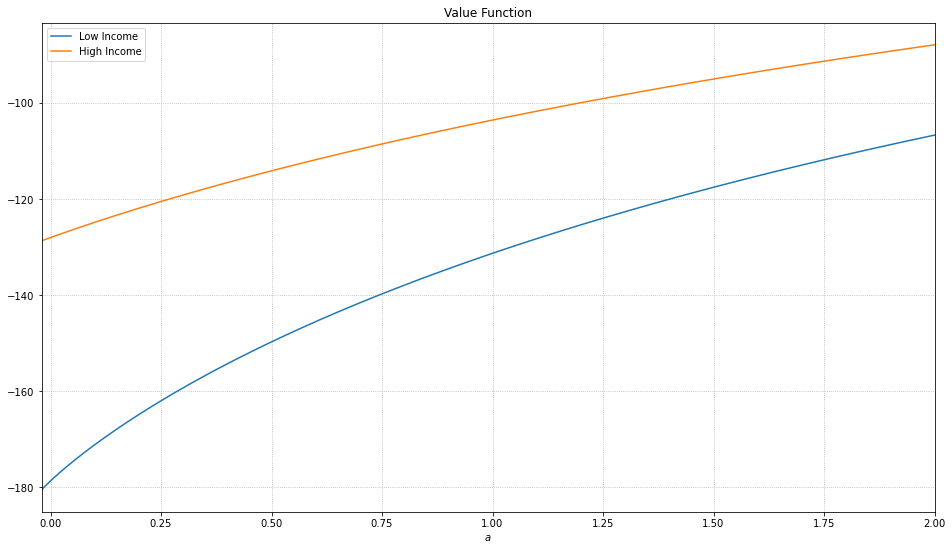

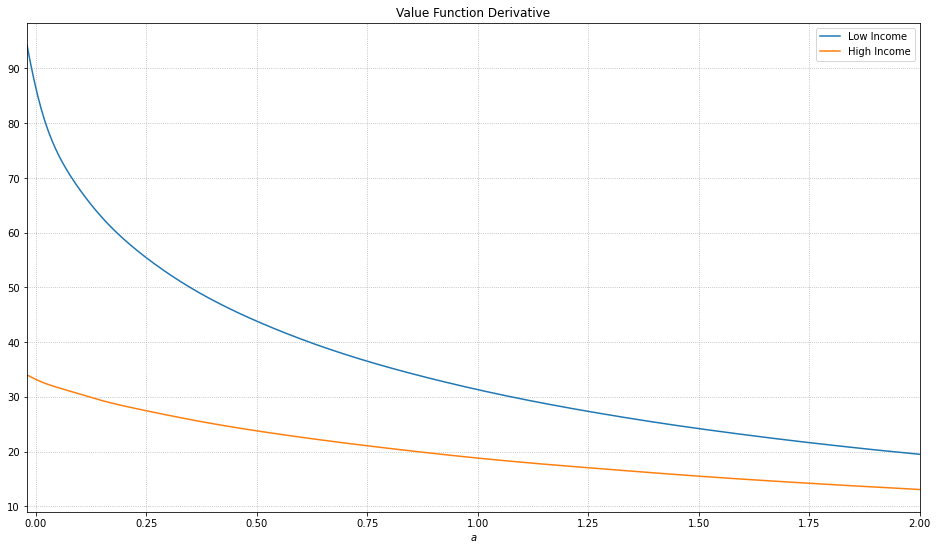

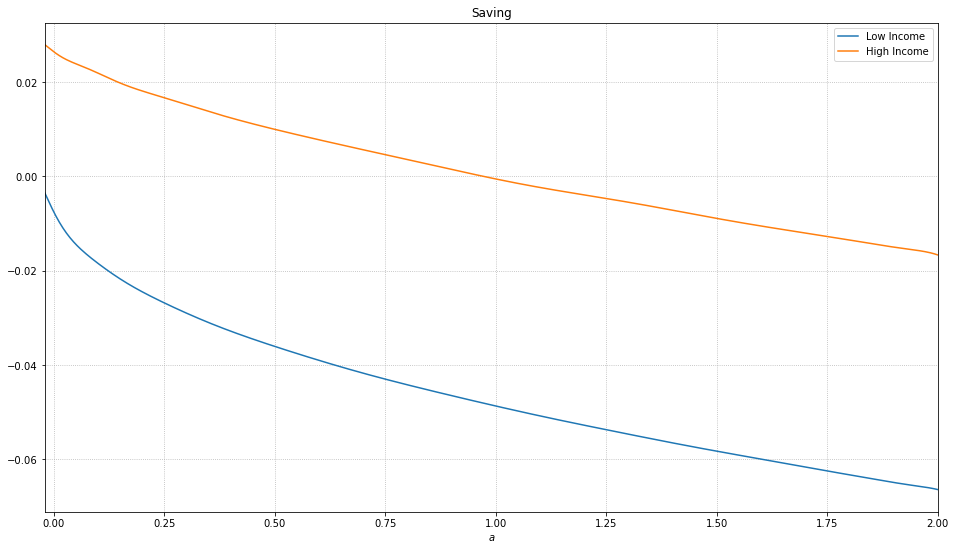

In [56]:
aspace = np.linspace(-0.02, 2, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A==-0.02].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:,0:1]
    tape.watch(a)
    V = model(tf.stack([a[:, 0]], axis=1))
    Va_1 = tape.gradient(V[:,0], a)
    Va_2 = tape.gradient(V[:, 1], a)
    Va = tf.concat([Va_1,Va_2],axis=1)

fitted_V = V.numpy().reshape(500, 2)
fitted_Va = Va.numpy().reshape(500,2)
fitted_saving = z+r*X_interior - u_deriv_inv(fitted_Va)

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_V[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_V[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_Va[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_Va[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function Derivative")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_saving[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_saving[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low,X_high)
plt.title("Saving")


In [57]:

def loss_differentialoperator_KFE(model, model_g, X):
    a = X[:, 0:1]

    V = model(tf.stack([a[:, 0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:, 0], a)[0],
                    tf.gradients(V[:, 1], a)[0]], axis=1)
    c = u_deriv_inv(V_a)

    s = z+r*a - c

    u = model_g(tf.stack([a[:, 0]], axis=1))

    s1_a = tf.gradients(s[:, 0], a)[0]
    s2_a = tf.gradients(s[:, 1], a)[0]

    u1_a = tf.gradients(u[:, 0], a)[0]
    u2_a = tf.gradients(u[:, 1], a)[0]


    diff_u_z1 = - s1_a + s[:,0] * u1_a - la[0] + la[1]*tf.exp(-(u[:,1] - u[:,0]))
    diff_u_z2 = - s2_a + s[:, 1] * u2_a - \
        la[1] + la[0]*tf.exp(-(u[:, 0] - u[:, 1]))

    diff_g = tf.concat([diff_u_z1, diff_u_z2], axis=0)

    L = tf.reduce_mean(tf.square(diff_g))
    return diff_g, L


def loss_differentialoperator_alower_KFE(model, model_g, X):
    a = X[:, 0:1]

    V = model(tf.stack([a[:, 0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:, 0], a)[0],
                    tf.gradients(V[:, 1], a)[0]], axis=1)
    V_a = tf.math.maximum(tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z + r * a), V_a)

    c_new = u_deriv_inv(V_a_new)

    s = z+r*a - c_new

    u = model_g(tf.stack([a[:, 0]], axis=1))

    s1_a = tf.gradients(s[:, 0], a)[0]
    s2_a = tf.gradients(s[:, 1], a)[0]

    u1_a = tf.gradients(u[:, 0], a)[0]
    u2_a = tf.gradients(u[:, 1], a)[0]

    diff_u_z1 = - s1_a + s[:, 0] * u1_a - \
        la[0] + la[1]*tf.exp(-(u[:, 1] - u[:, 0]))
    diff_u_z2 = - s2_a + s[:, 1] * u2_a - \
        la[1] + la[0]*tf.exp(-(u[:, 0] - u[:, 1]))

    diff_g = tf.concat([diff_u_z1, diff_u_z2], axis=0)
    
    L = tf.reduce_mean(tf.square(diff_g))

    return diff_g, L



def compute_loss_KFE(model, model_g, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    '''

    Loss_V_interior, L1 = loss_differentialoperator_KFE(
        model, model_g, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower_KFE(
        model, model_g, X_alower)


    L = L1 + L2 
    # L = L1

    return L


def get_grad_KFE(model, model_g, X_interior, X_alower):

    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model_g.trainable_variables)
        loss = compute_loss_KFE(model, model_g, X_interior, X_alower)

    grad = tape.gradient(loss, model_g.trainable_variables)
    del tape

    return loss, grad


model_g = DCGMNet(X_low, X_high,
                dim_input, dim_output,
                num_layers_FFNN, nodes_per_layer,
                activation_FFNN)


In [58]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)


@tf.function
def train_step_KFE(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad_KFE(model, model_g, X_interior, X_alower)

    # Perform gradient descent step
    optimizer2.apply_gradients(zip(grad_theta, model_g.trainable_variables))

    return loss


hist = []

for i in range(3000):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(2048, 1)

    for _ in range(steps_per_sample):
        loss = train_step_KFE(X_interior, X_alower)

    hist.append(loss.numpy())

    if i % 100 == 0:
        tf.print(i, loss)


0 0.0253258348
100 0.000238237131
200 0.000216111323
300 0.00019814643
400 0.000206289958
500 0.000213628344
600 0.000186878562


Text(0.5, 1.0, 'Density')

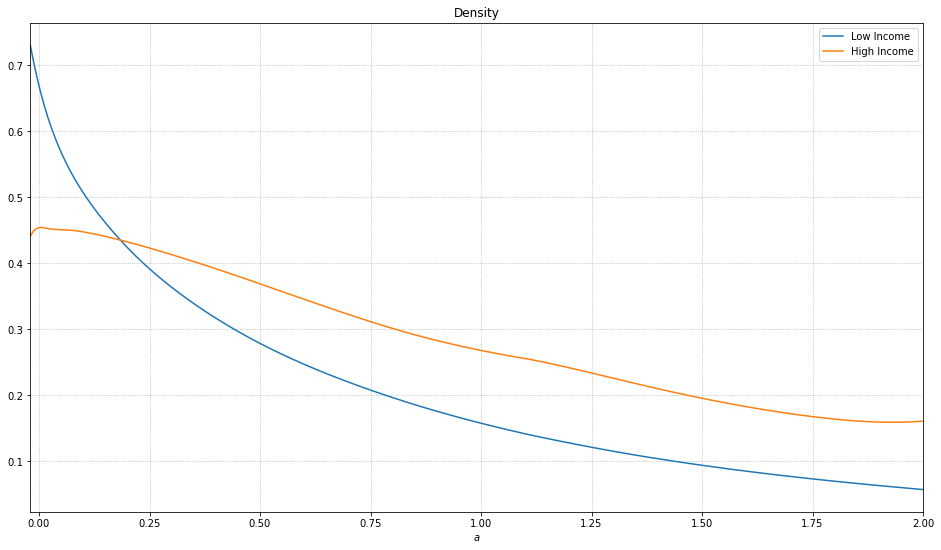

In [50]:

aspace = np.linspace(-0.02, 2, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A == -0.02].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:, 0:1]
    tape.watch(a)
    u = model_g(tf.stack([a[:, 0]], axis=1))
    
del tape

# g = tf.exp(-u)/tf.reduce_sum(tf.exp(-u))
# g = tf.exp(-u)
u = u.numpy().reshape(500, 2)

p = np.exp(-u)

fitted_g = p/(np.trapz(p[:, 0], aspace)
              + np.trapz(p[:, 1], aspace)
              )


fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_g[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_g[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Density")

